## **Sentiment Based Text Classification on Amazon Reviews Using BERT**

User reviews are an important source of information for both businesses and customers. To analyse and understand these reviews, a Natural Language Processing technique called Sentiment analysis is used. We will finetune a pretrained BERT model from Hugginface on Amazon polarity database.

In [ ]:
%%capture
!pip install datasets pandas matplotlib seaborn --quiet
!pip install -U datasets fsspec --quiet

In [ ]:
#Import Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TrainerCallback
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re
import torch

In [ ]:
%%capture
# Load the IMDB dataset from HuggingFace
dataset = load_dataset("amazon_polarity")

In [ ]:
# Print the number of rows in traning and test data sets
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

#### **Exploratory Data Analysis**

EDA helps understand more about the data, A subset of the data , sentiment class distribution,null and duplicates values and the length of the reviews are identified in this section

In [ ]:
# print the  first 10 rows of the train dataset
df = dataset['train'].to_pandas()
df.head(10)

,label,title,content
0,1,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,1,Amazing!,This soundtrack is my favorite music of all ti...
3,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
5,1,an absolute masterpiece,I am quite sure any of you actually taking the...
6,0,Buyer beware,"This is a self-published book, and if you want..."
7,1,Glorious story,I loved Whisper of the wicked saints. The stor...
8,1,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
9,1,Whispers of the Wicked Saints,This was a easy to read book that made me want...


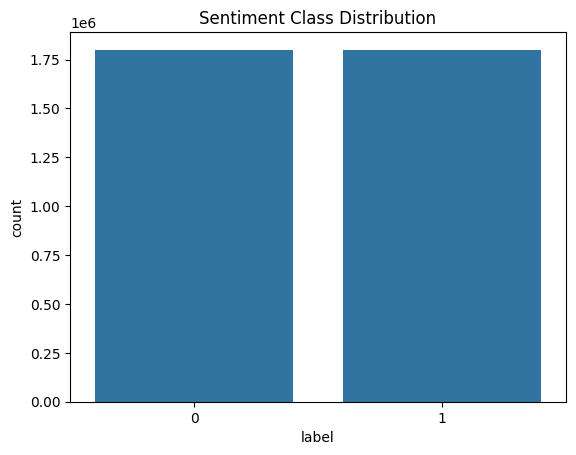

In [ ]:
# Plot sentiment label counts
sns.countplot(x='label', data=df)
plt.title('Sentiment Class Distribution')
plt.show()

In [ ]:
# Check nulls
print(df.isnull().sum())

label      0
title      0
content    0
dtype: int64


In [ ]:
# Check duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


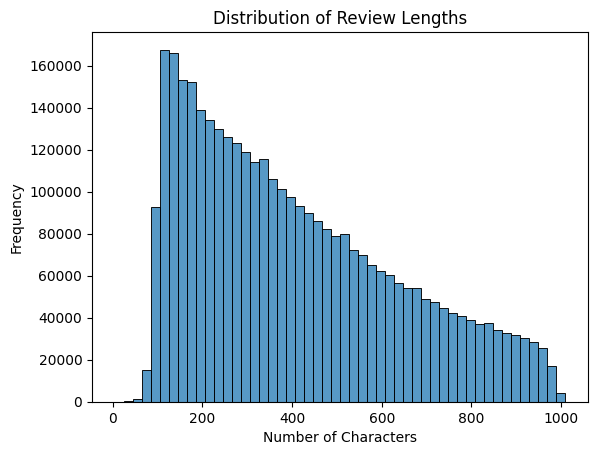

In [ ]:
# Plot histogram of length of reviews
df['content_length'] = df['content'].apply(len)
sns.histplot(df['content_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Print some stats
print(df['content_length'].describe())

count    3.600000e+06
mean     4.051396e+02
std      2.342711e+02
min      4.000000e+00
25%      2.070000e+02
50%      3.560000e+02
75%      5.660000e+02
max      1.010000e+03
Name: content_length, dtype: float64


#### **Data Preprocessing**

Preprocessing steps are applied to the dataset in this section, Preprocessing steps included lowercasing, removing special characters and extra whitespace, and truncating long inputs. The cleaned text was then tokenized using the Bert-
base-uncased tokenizer, which converts text into input IDs and attention masks suitable for BERT.

In [ ]:
def clean_text(text):
    """
    Cleans input text by applying preprocessing steps:
    Args:
        text (str): The text string to clean.

    Returns:
        str: The cleaned text string.
    """
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
def preprocess_function(examples):

  '''
  input : text
  output : tokenized text
  '''
  cleaned_texts = [clean_text(t) for t in examples["content"]]
  return tokenizer(
      cleaned_texts,
      truncation=True,
      padding='max_length',
      max_length=128
    )

In [ ]:
# Take subset for model training
train_dataset = dataset["train"].shuffle(seed=42).select(range(10000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(2000))

# Create Validation dataset
split = train_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split["train"]
val_dataset = split["test"]

In [ ]:
# Assign the model name and tokenizer to variables
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# Apply  the preprocess function to datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train = tokenized_train.remove_columns(["content", "title"])
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_train.set_format("torch")
tokenized_test = tokenized_test.remove_columns(["content", "title"])
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch")

#### **Model Implementation**

Here the  pretrained model will be loaded by passing the model_checkpoint name, then variables for storing the metrics are defined. A callback class is defined for capturing the metrics values during training.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Lists to store metrics for plotting
train_loss_values = []
eval_accuracy = []
eval_f1 = []
eval_precision = []
eval_recall = []

In [ ]:
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        # Store training loss
        if 'loss' in logs:
            train_loss_values.append(logs['loss'])

        # Store eval metrics
        if 'eval_accuracy' in logs:
            eval_accuracy.append(logs['eval_accuracy'])
        if 'eval_f1' in logs:
            eval_f1.append(logs['eval_f1'])
        if 'eval_precision' in logs:
            eval_precision.append(logs['eval_precision'])
        if 'eval_recall' in logs:
            eval_recall.append(logs['eval_recall'])

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

#### **Hyperparameter Tuning**
In this section the model is trained on two learing rates to find out which one would yield the best results. The metrics are colleced in results dictionary and this will comapred to select the best model.

In [ ]:
# Define learing rates and results dictionary for hyperparameter tuning
learning_rates = [2e-5, 3e-5]
results = {
    "learning_rate": [],
    "eval_accuracy": [],
    "eval_f1": [],
    "eval_precision": [],
    "eval_recall": [],
    "eval_loss": []
}

In [ ]:
# Function to return a fresh model for each run
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2
    )

In [ ]:
# Loop through learning rates
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    training_args = TrainingArguments(
        output_dir=f"./results_lr_{lr}",
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        logging_steps=10,
        eval_strategy="steps",
        eval_steps=40,
        save_strategy="no",
    )

    trainer = Trainer(
        model=model_init(),
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Evaluate
    metrics = trainer.evaluate()
    print(f"Metrics for lr={lr}: {metrics}")

    # Store metrics
    results["learning_rate"].append(lr)
    results["eval_accuracy"].append(metrics.get("eval_accuracy", 0))
    results["eval_f1"].append(metrics.get("eval_f1", 0))
    results["eval_precision"].append(metrics.get("eval_precision", 0))
    results["eval_recall"].append(metrics.get("eval_recall", 0))
    results["eval_loss"].append(metrics.get("eval_loss", 0))

# Convert to numpy arrays
results = {k: np.array(v) for k, v in results.items()}

# Find the best learning rate
best_idx = np.argmax(results["eval_accuracy"])
best_lr = results["learning_rate"][best_idx]
print(f"\n Results: {results}")
print(f"\nBest learning rate: {best_lr}")


Training with learning rate: 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-28-3176924842.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
40,0.559900,0.496191,0.800500,0.777219,0.900388,0.683694
80,0.341900,0.326943,0.862500,0.874257,0.817793,0.939096
120,0.334300,0.262389,0.900000,0.903195,0.890267,0.916503
160,0.237100,0.256540,0.898500,0.901790,0.888465,0.915521
200,0.301300,0.263120,0.897500,0.893947,0.944262,0.848723
240,0.262500,0.236922,0.904500,0.904357,0.922370,0.887033
280,0.154700,0.359098,0.882500,0.892645,0.834330,0.959725
320,0.155300,0.251943,0.906500,0.908647,0.903790,0.913556
360,0.221500,0.247746,0.907000,0.908913,0.906250,0.911591
400,0.208500,0.246144,0.912500,0.912369,0.930541,0.894892


Metrics for lr=2e-05: {'eval_loss': 0.23691710829734802, 'eval_accuracy': 0.911, 'eval_f1': 0.9136760426770126, 'eval_precision': 0.9022988505747126, 'eval_recall': 0.925343811394892, 'eval_runtime': 15.1923, 'eval_samples_per_second': 131.645, 'eval_steps_per_second': 8.228, 'epoch': 1.0}

Training with learning rate: 3e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-28-3176924842.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
40,0.383400,0.361113,0.867500,0.871172,0.862368,0.880157
80,0.370000,0.279949,0.886000,0.888126,0.887255,0.888998
120,0.422200,0.307563,0.894500,0.900142,0.868493,0.934185
160,0.272200,0.264214,0.894500,0.900142,0.868493,0.934185
200,0.321400,0.255389,0.895000,0.889822,0.954955,0.833006
240,0.299500,0.239737,0.900000,0.897119,0.941685,0.856582
280,0.172800,0.345816,0.888000,0.896964,0.843426,0.957760
320,0.177600,0.243587,0.911000,0.911881,0.919162,0.904715
360,0.240000,0.246245,0.914000,0.916424,0.906731,0.926326
400,0.242500,0.237272,0.915500,0.916212,0.924925,0.907662


Metrics for lr=3e-05: {'eval_loss': 0.2400527149438858, 'eval_accuracy': 0.9165, 'eval_f1': 0.9184968277208394, 'eval_precision': 0.9127061105722599, 'eval_recall': 0.9243614931237721, 'eval_runtime': 15.1713, 'eval_samples_per_second': 131.828, 'eval_steps_per_second': 8.239, 'epoch': 1.0}

 Results: {'learning_rate': array([2.e-05, 3.e-05]), 'eval_accuracy': array([0.911 , 0.9165]), 'eval_f1': array([0.91367604, 0.91849683]), 'eval_precision': array([0.90229885, 0.91270611]), 'eval_recall': array([0.92534381, 0.92436149]), 'eval_loss': array([0.23691711, 0.24005271])}

Best learning rate: 3e-05


#### **Training The Best Model**

Afte the Hyperparameter tuning the best learning rate was found to be 3e-05 , so the model will be trained on this for two epochs and the corresponding results will be plotted as graphs

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=40,
    save_strategy="no"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[MetricsCallback()]
)


/tmp/ipython-input-38-1944685878.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
#Train the model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
40,0.069400,0.659975,0.894000,0.889583,0.946785,0.838900
80,0.145600,0.567502,0.902500,0.900154,0.940107,0.863458
120,0.047400,0.520514,0.908500,0.909000,0.920443,0.897839
160,0.004400,0.598010,0.896500,0.893573,0.937433,0.853635
200,0.097800,0.448480,0.905000,0.909351,0.884045,0.936149
240,0.106300,0.499246,0.911000,0.913086,0.907767,0.918468
280,0.093800,0.618990,0.889500,0.896970,0.853594,0.944990
320,0.001800,0.559468,0.910000,0.910803,0.919000,0.902750
360,0.060400,0.503401,0.906000,0.908382,0.901354,0.915521
400,0.121100,0.413615,0.908000,0.910506,0.901734,0.919450


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
40,0.069400,0.659975,0.894000,0.889583,0.946785,0.838900
80,0.145600,0.567502,0.902500,0.900154,0.940107,0.863458
120,0.047400,0.520514,0.908500,0.909000,0.920443,0.897839
160,0.004400,0.598010,0.896500,0.893573,0.937433,0.853635
200,0.097800,0.448480,0.905000,0.909351,0.884045,0.936149
240,0.106300,0.499246,0.911000,0.913086,0.907767,0.918468
280,0.093800,0.618990,0.889500,0.896970,0.853594,0.944990
320,0.001800,0.559468,0.910000,0.910803,0.919000,0.902750
360,0.060400,0.503401,0.906000,0.908382,0.901354,0.915521
400,0.121100,0.413615,0.908000,0.910506,0.901734,0.919450


TrainOutput(global_step=1250, training_loss=0.055199036108329894, metrics={'train_runtime': 873.3453, 'train_samples_per_second': 22.9, 'train_steps_per_second': 1.431, 'total_flos': 1315555276800000.0, 'train_loss': 0.055199036108329894, 'epoch': 2.0})

In [ ]:
# get the training metric results
logs = trainer.state.log_history
df = pd.DataFrame(logs)
eval_logs = df[df.eval_loss.notna()]
print(eval_logs)

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
4     NaN        NaN            NaN  0.064    40   0.659975         0.8940   
9     NaN        NaN            NaN  0.128    80   0.567502         0.9025   
14    NaN        NaN            NaN  0.192   120   0.520514         0.9085   
19    NaN        NaN            NaN  0.256   160   0.598010         0.8965   
24    NaN        NaN            NaN  0.320   200   0.448480         0.9050   
29    NaN        NaN            NaN  0.384   240   0.499246         0.9110   
34    NaN        NaN            NaN  0.448   280   0.618990         0.8895   
39    NaN        NaN            NaN  0.512   320   0.559468         0.9100   
44    NaN        NaN            NaN  0.576   360   0.503401         0.9060   
49    NaN        NaN            NaN  0.640   400   0.413615         0.9080   
54    NaN        NaN            NaN  0.704   440   0.444578         0.9080   
59    NaN        NaN            NaN  0.768   480   0.435816     

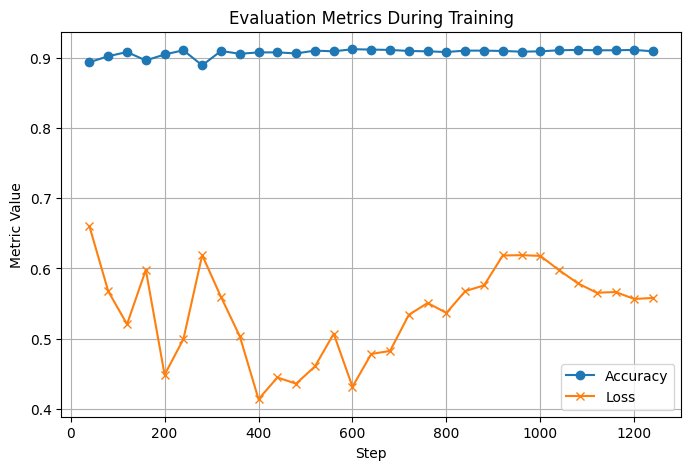

In [ ]:
#Plot Accuracy and Loss during training

plt.figure(figsize=(8,5))
plt.plot(eval_logs["step"], eval_logs["eval_accuracy"], label="Accuracy", marker='o')
plt.plot(eval_logs["step"], eval_logs["eval_loss"], label="Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title("Evaluation Metrics During Training")
plt.grid()
plt.show()

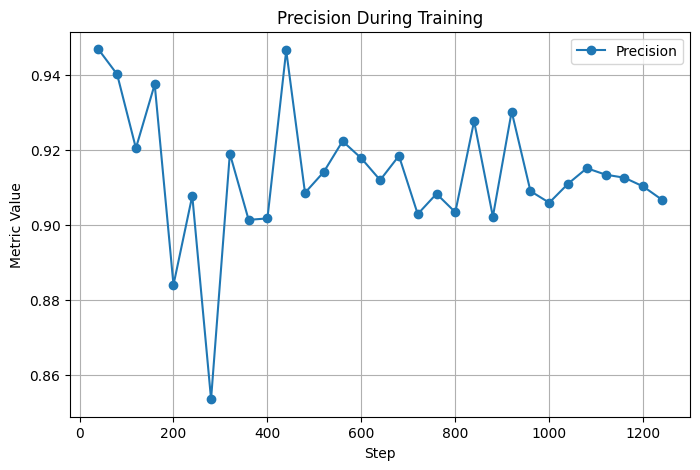

In [ ]:
#Precision During Training

plt.figure(figsize=(8,5))
plt.plot(eval_logs["step"], eval_logs["eval_precision"], label="Precision", marker='o')
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title("Precision During Training")
plt.grid()
plt.show()

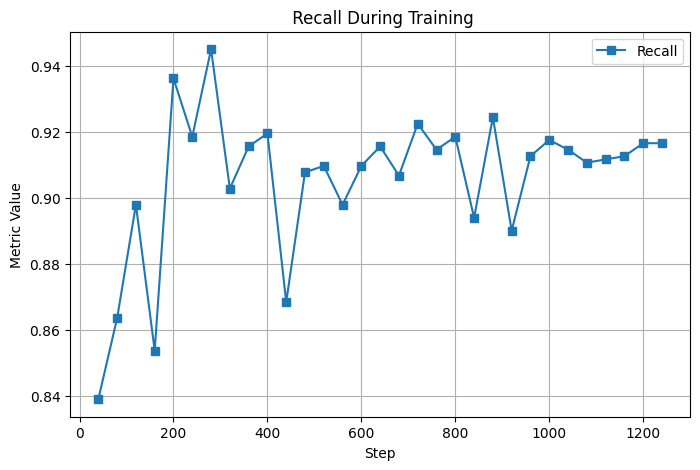

In [ ]:
#Recall During Training

plt.figure(figsize=(8,5))
plt.plot(eval_logs["step"], eval_logs["eval_recall"], label="Recall", marker='s')
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title(" Recall During Training")
plt.grid()
plt.show()

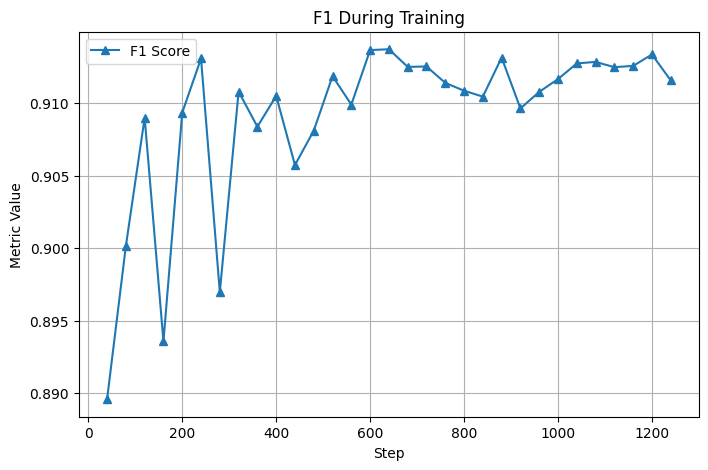

In [ ]:
#F1-score during training

plt.figure(figsize=(8,5))
plt.plot(eval_logs["step"], eval_logs["eval_f1"], label="F1 Score", marker='^')
plt.xlabel("Step")
plt.ylabel("Metric Value")
plt.legend()
plt.title("F1 During Training")
plt.grid()
plt.show()

#### **Save and Load the trained model**

In [ ]:
# Save model and tokenizer
trainer.save_model("/content/drive/Othercomputers/My Mac/LLM/saved_models/model")
tokenizer.save_pretrained("/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer")

('/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/tokenizer_config.json',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/special_tokens_map.json',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/vocab.txt',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/added_tokens.json',
 '/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer/tokenizer.json')

In [ ]:
# Load the saved model
model_path = "/content/drive/Othercomputers/My Mac/LLM/saved_models/model"
tokenizer_path = "/content/drive/Othercomputers/My Mac/LLM/saved_models/tokenizer"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

#### **Model Inference**

The trained model infered to find the prediction results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
N = 10

for example in val_dataset.select(range(N)):
    text = example["content"]

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding=True
    )

    # Move tensors to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediction
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_class = torch.argmax(outputs.logits, dim=-1).item()

    print(f"Text: {text}")
    print(f"Predicted label: {predicted_class}")
    print("-" * 80)

Text: I did not like this book. I studied all of the cultural perspetive sections (geography, lifestyle, sociolenguitic elements, history, arts and literature). None of it appear in the Georgia spanish exam. It was a waste of time and money. I did not like the format of the book either.
Predicted label: 0
--------------------------------------------------------------------------------
Text: Note: this is a review is specific for theThe Hound of the Baskervillesedition and not the book as a whole. The free kindle edition is missing any passage that would be considered source material in the book. If the character reads from a document, a newspaper, etc... it's just gone. Very disappointing. Don't bother with this version.
Predicted label: 0
--------------------------------------------------------------------------------
Text: A lot of reviewers who like this movie tell people who didn't like the movie to read the book. Why read the book when we are trying to watch a good movie? Let's be